<a href="https://colab.research.google.com/github/infomon/understanding_cnn/blob/master/notebooks/Compare_networks_on_ImageNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compare networks on ImageNet

## Imports


In [1]:
!pip install scipy==1.2.0
!pip install wget
!pip install -q git+https://github.com/albermax/innvestigate
!pip install -q deeplift
!git clone https://github.com/infomon/understanding_cnn
  
import shutil
import os
if not os.path.isfile("utils.py"):
  shutil.move("/content/understanding_cnn/utils/utils.py", "/content")
if not os.path.isfile("utils_imagenet.py"):
  shutil.move("/content/understanding_cnn/utils/utils_imagenet.py", "/content")
if not os.path.isdir("models"):
  shutil.move("/content/understanding_cnn/models", "/content")
if not os.path.isdir("images"):
  shutil.move("/content/understanding_cnn/data/images", "/content")
if not os.path.isfile("data_loader.py"):
  shutil.move("/content/understanding_cnn/data/data_loader.py", "/content")
  
!rm -r understanding_cnn

Cloning into 'understanding_cnn'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 286 (delta 28), reused 10 (delta 4), pack-reused 221
Receiving objects: 100% (286/286), 34.61 MiB | 29.41 MiB/s, done.
Resolving deltas: 100% (131/131), done.


In [0]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

In [3]:
%matplotlib inline  

import imp
import numpy as np
import os

import keras
import keras.backend
import keras.models

import innvestigate
import innvestigate.applications.imagenet
import innvestigate.utils as iutils

import models.model_loader as model_loader
import data_loader

# Use utility libraries to focus on relevant iNNvestigate routines.
eutils = imp.load_source("utils", "utils.py")
imgnetutils = imp.load_source("utils_imagenet", "utils_imagenet.py")

# We create many graphs, let's not run out of memory.
if keras.backend.backend() == "tensorflow":
    config = keras.backend.tf.ConfigProto()
    config.gpu_options.allow_growth = True
    keras.backend.set_session(keras.backend.tf.Session(config=config))

Using TensorFlow backend.
W0414 13:59:54.163398 139767654561664 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


## Models, data and analyzers

In [0]:
# Choose a list of models
netnames = [
    # NAME                  MODEL LOADER
    #["AlexNet",             model_loader.AlexNet],
    ["VGG19",               model_loader.VGG19],
    ["Resnet_v1_101",       model_loader.Resnet_v1_101],
    ["Inception_v3",        model_loader.Inception_v3],
    ["Inception_Resnet_v2", model_loader.Inception_Resnet_v2]
]          
n_nets = len(netnames)

The following function will load a specific model, load the data in the respective format and create analyzers for this model.

**For a better understanding of this part we refer to the [Comparing networks on ImagenNet](imagenet_network_comparison.ipynb) notebook, from which this code segment is adopted from.**

In [0]:
def prepare_model_data_and_analyzers(loader):
    # Load the model definition.
    model = loader(include_top=True, weights='imagenet')

    # Get some example test set images.
    data = data_loader.load_from_folder("images",model.get_image_size())

    
    images = [] 
    label_to_class_name = []
    for img,label in data:
      images.append(img)
      label_to_class_name.append(label)
      
    
    patterns = model.get_patterns()
    input_range = (-1,1)

    noise_scale = (input_range[1]-input_range[0]) * 0.1

    # Methods we use and some properties.
    methods = [
        # NAME                    OPT.PARAMS                POSTPROC FXN                TITLE
        # Show input.
        ("input",                 {},                       imgnetutils.image,         "Input"), #0

        # Function
        ("gradient",              {"postprocess": "abs"},   imgnetutils.graymap,       "Gradient"), #1
        ("smoothgrad",            {"augment_by_n": 16,
                                   "noise_scale": noise_scale,
                                   "postprocess": "square"},imgnetutils.graymap,       "SmoothGrad"), #2

        # Signal
        ("deconvnet",             {},                       imgnetutils.bk_proj,       "Deconvnet"), #3
        ("guided_backprop",       {},                       imgnetutils.bk_proj,       "Guided Backprop",), #4
        ("pattern.net",           {"patterns": patterns},   imgnetutils.bk_proj,       "PatternNet"), #5

        # Interaction
        ("pattern.attribution",   {"patterns": patterns},   imgnetutils.heatmap,       "PatternAttribution"), #6
        ("deep_taylor.bounded",   {"low": input_range[0],
                                   "high": input_range[1]}, imgnetutils.heatmap,       "DeepTaylor"), #7
        ("input_t_gradient",      {},                       imgnetutils.heatmap,       "Input * Gradient"), #8
        ("integrated_gradients",  {"reference_inputs": input_range[0],
                                   "steps": 16},            imgnetutils.heatmap,       "Integrated Gradients"), #9
        ("lrp.epsilon",           {"epsilon": 1},           imgnetutils.heatmap,        "LRP-Epsilon"), #10
        ("lrp.epsilon_IB",           {"epsilon": 1},           imgnetutils.heatmap,        "LRP-Epsilon IB"), #11
        ("lrp.alpha_1_beta_0",           {},           imgnetutils.heatmap,        "LRP-Alpha1-Beta0"), #12
        ("lrp.alpha_1_beta_0_IB",           {},           imgnetutils.heatmap,        "LRP-Alpha1-Beta0 IB"), #13
        ("lrp.sequential_preset_a_flat",{"epsilon": 1},     imgnetutils.heatmap,       "LRP-PresetAFlat"), #14 
        ("lrp.sequential_preset_b_flat",{"epsilon": 1},     imgnetutils.heatmap,       "LRP-PresetBFlat"), #15
    ]
    
    # Select methods of your choice
    selected_methods_indices = [0,1,4,5,6,14,15]
    selected_methods = [methods[i] for i in selected_methods_indices]
    print('Using method(s) "{}".'.format([method[0] for method in selected_methods]))
    
    # Create model without trailing softmax
    model_wo_softmax = model.get_model()

    # Create analyzers.
    analyzers = []
    for method in selected_methods:
        try:
            analyzer = innvestigate.create_analyzer(method[0],        # analysis method identifier
                                                    model_wo_softmax, # model without softmax output
                                                    allow_lambda_layers=True,
                                                    **method[1])      # optional analysis parameters
        except innvestigate.NotAnalyzeableModelException as e:
            analyzer = None
            print(method[3]+" cannot be used!")
            print(str(e))
        analyzers.append(analyzer)
        
    return (images, label_to_class_name,
            selected_methods, model, model_wo_softmax, analyzers)

## Analysis

Now we analyze each image with the different networks and different analyzers:

In [6]:
import matplotlib.pyplot as plt

analyses = {}
texts = {}
    
for (netname,loader) in netnames:
    print("Creating analyses for network {}.".format(netname))
    tmp = prepare_model_data_and_analyzers(loader)
    (images, label_to_class_name,
     methods, model, model_wo_softmax, analyzers) = tmp
    
    analysis = np.zeros([len(images), len(analyzers)]+list(model.get_image_size())+[3])
    text = []
    
    channels_first = keras.backend.image_data_format() == "channels_first"
    color_conversion = "BGRtoRGB" if model.get_color_coding() == "BGR" else None

    for i, x in enumerate(images):
        # Add batch axis.
        x_pp = model.preprocess_input(x)

        # Predict final activations, probabilites, and label.
        presm = model.predict_wo_softmax(x_pp)[0]
        prob = model.predict_with_softmax(x_pp)[0]
        y_hat = prob.argmax()

        # Save prediction info:
        text.append(("%s" % label_to_class_name[i],    # ground truth label
                     "%.2f" % presm.max(),             # pre-softmax logits
                     "%.2f" % prob.max(),              # probabilistic softmax output  
                     "%s" % model.decode_predictions(prob[None,...], top=1)[0][0][1] # predicted label
                    ))

        for aidx, analyzer in enumerate(analyzers):
            #print(methods[aidx][0]+" for image with label "+label_to_class_name[i])
            if methods[aidx][0] == "input":
                # Do not analyze, but keep not preprocessed input.
                a = x
                analysis[i, 0] = a
            elif analyzer:
                # Analyze.
                a = analyzer.analyze(x_pp)

                # Apply common postprocessing, e.g., re-ordering the channels for plotting.
                a = imgnetutils.postprocess(a, color_conversion, channels_first)
                # Apply analysis postprocessing, e.g., creating a heatmap.
                a = methods[aidx][2](a)
            else:
                a = np.zeros_like(x)
            # Store the analysis.
            if methods[aidx][0] != "input":
              analysis[i, aidx] = a[0]

        analyses[netname] = analysis
        texts[netname] = text

Creating analyses for network VGG19.
Instructions for updating:
Colocations handled automatically by placer.


W0414 13:59:54.898299 139767654561664 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Using method(s) "['input', 'gradient', 'guided_backprop', 'pattern.net', 'pattern.attribution', 'lrp.sequential_preset_a_flat', 'lrp.sequential_preset_b_flat']".
Instructions for updating:
Use tf.cast instead.


W0414 14:00:02.172838 139767654561664 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


W0414 14:00:02.197723 139767654561664 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Creating analyses for network Resnet_v1_101.
Using method(s) "['input', 'gradient', 'guided_backprop', 'pattern.net', 'pattern.attribution', 'lrp.sequential_preset_a_flat', 'lrp.sequential_preset_b_flat']".
PatternNet cannot be used!
PatternNet is only well defined for conv2d/max-pooling/dense layers.
Check triggerd by layers: [<keras.layers.convolutional.ZeroPadding2D object at 0x7f1db2470278>, <keras.layers.normalization.BatchNormalization object at 0x7f1db247fa90>, <keras.layers.core.Activation object at 0x7f1db24102e8>, <keras.layers.convolutional.ZeroPadding2D object at 0x7f1db23b3f28>, <keras.layers.normalization.BatchNormalization object at 0x7f1db22c4828>, <keras.layers.core.Activation object at 0x7f1db2283320>, <keras.layers.normalization.BatchNormalization object at 0x7f1db20cb278>, <keras.layers.core.Activation object at 0x7f1db20dbc50>, <keras.layers.normalization.BatchNormalization object at 0x7f1db228a4e0>, <keras.layers.normalization.BatchNormalization object at 0x7f1db1

Next, we visualize the analysis results:

W0414 14:16:43.588516 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0414 14:16:43.712186 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image nr. 0, true label: airliner


W0414 14:16:43.840993 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0414 14:16:43.971838 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

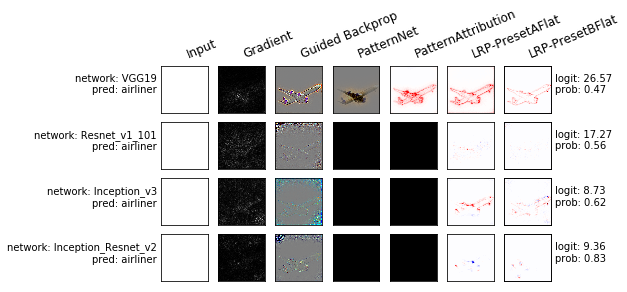

W0414 14:16:45.119975 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0414 14:16:45.252930 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image nr. 1, true label: leopard


W0414 14:16:45.389534 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0414 14:16:45.522390 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

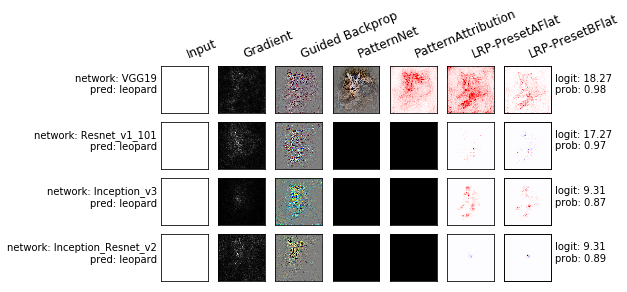

W0414 14:16:46.671923 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0414 14:16:46.796057 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image nr. 2, true label: bullet_train


W0414 14:16:46.933643 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0414 14:16:47.068460 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

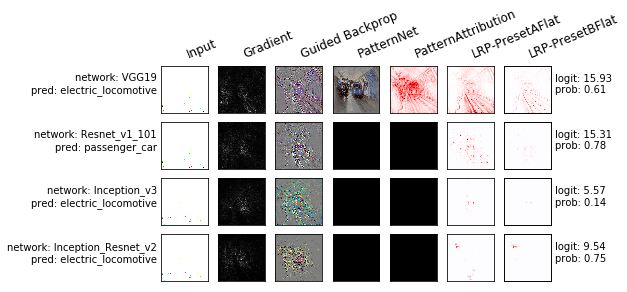

W0414 14:16:48.189676 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0414 14:16:48.344035 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image nr. 3, true label: partridge


W0414 14:16:48.480168 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0414 14:16:48.613598 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

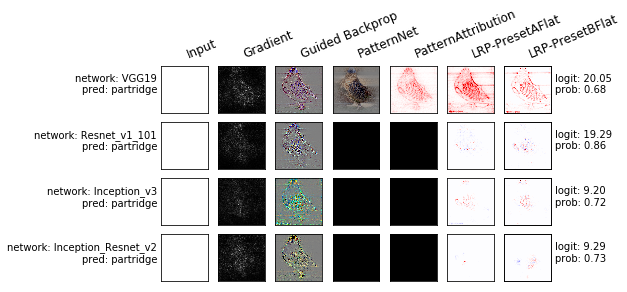

W0414 14:16:49.751091 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0414 14:16:49.886109 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image nr. 4, true label: Tibetan_mastiff


W0414 14:16:50.022048 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0414 14:16:50.155331 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

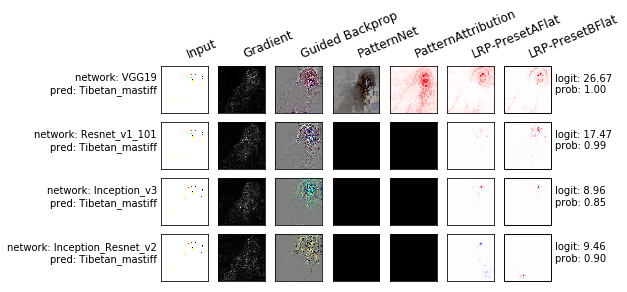

W0414 14:16:51.307638 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0414 14:16:51.451843 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image nr. 5, true label: Siberian_husky


W0414 14:16:51.589262 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0414 14:16:51.722103 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

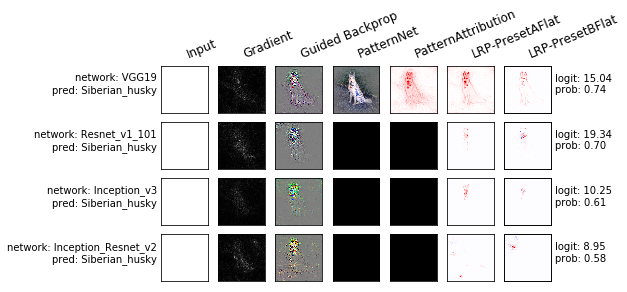

W0414 14:16:52.891693 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0414 14:16:53.020410 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image nr. 6, true label: accordion


W0414 14:16:53.158542 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0414 14:16:53.295057 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

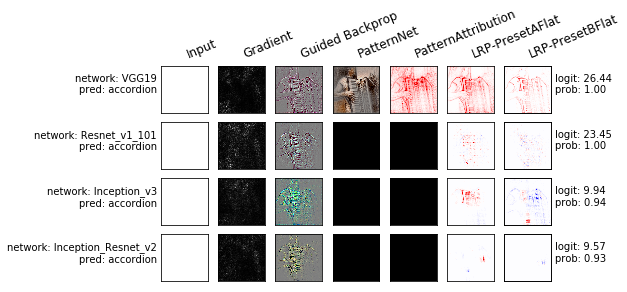

W0414 14:16:54.444929 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0414 14:16:54.584960 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image nr. 7, true label: tabby


W0414 14:16:54.721804 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0414 14:16:54.859050 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

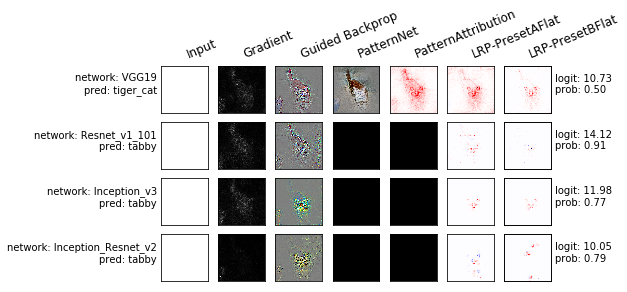

W0414 14:16:56.008150 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0414 14:16:56.133082 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image nr. 8, true label: baseball


W0414 14:16:56.272749 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0414 14:16:56.412968 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

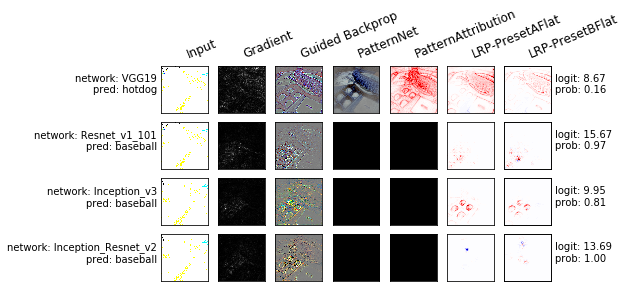

W0414 14:16:57.568776 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0414 14:16:57.706753 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image nr. 9, true label: African_elephant


W0414 14:16:57.846014 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0414 14:16:57.982502 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

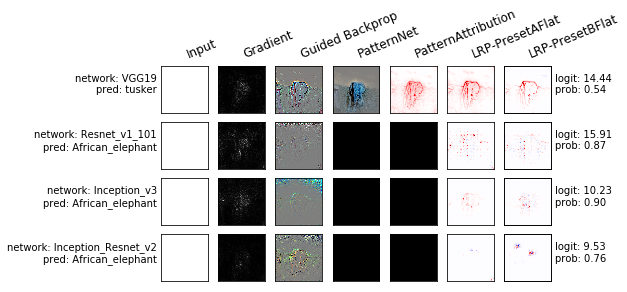

W0414 14:16:59.134078 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0414 14:16:59.261076 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image nr. 10, true label: sorrel


W0414 14:16:59.402771 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0414 14:16:59.541414 139767654561664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

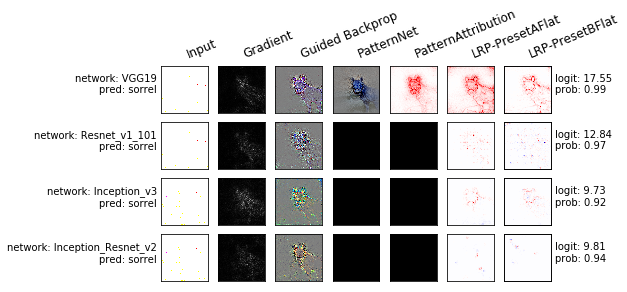

In [7]:
n_images = analyses[netnames[0][0]].shape[0]

# Prepare common labels
col_labels = [''.join(method[3]) for method in methods]

for image_index in range(n_images):
    grid = []
    row_labels_left = []
    row_labels_right = []
    
    for netname,_ in netnames:
        analysis, text = analyses[netname], texts[netname]
        # Prepare the grid as rectengular list
        grid.append([analysis[image_index, j] for j in range(analysis.shape[1])])
        # Prepare the labels
        label, presm, prob, pred = zip(*text)
        label = label[image_index]
        row_labels_left.append(('network: {}'.format(netname),'pred: {}'.format(pred[image_index])))
        row_labels_right.append(('logit: {}'.format(presm[image_index]),'prob: {}'.format(prob[image_index])))

    # Plot the analysis.
    print("Image nr. {}, true label: {}".format(image_index, label))
    eutils.plot_image_grid(grid, row_labels_left, row_labels_right, col_labels,
                           file_name=os.environ.get("plot_file_name", None))

This figures show the analysis regarding the *actually predicted* class as computed by the selected analyzers. Each column shows the visualized results for different analyzers and each row shows the analyses wrt to one input sample. To the left of each row, the ground truth label `label` and the predicted label `pred` are show. To the right, the model's probabilistic (softmax) output is shown as `prob` and the logit output just before the terminating softmax layer as `logit`. Note that all analyses have been performed based on the logit output (layer).